In [1]:
!pip install praw pandas seaborn scipy nltk scikit-learn spacy polars

In [2]:
import csv
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
import time
from typing import Callable

from bins import TimeRange
from config import Config, CONFIG_FILE_NAME
from util import *
import validate

sns.set_theme()

In [3]:
# To ensure everything's nice and deterministic
random.seed(0)
np.random.seed(0)

In [4]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [4]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [5]:
keywords = [
    r"trauma",
    r"gaslight",
    r"trigger",
    r"toxic",
    r"manipulat",
    r"microaggression",
    r"autis",
    r"adhd",
    r"ocd",
    r"ptsd",
    r"bipolar",
    r"anxiety",
    r"depress",
    r"psycho",
    r"delusion",
    r"addict",
    r"abus",
    r"unstable",
    r"narcissis",
    r"addict",
    r"neurodivergen",
]

In [6]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [7]:
runs = get_runs()
missing_runs = validate.missing_runs(runs.keys())
assert len(missing_runs) == 0, missing_runs

In [8]:
df = load_comments(*runs.values())
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151671549,2009-12-31 19:01:19,IAmA,NaN,t3_ak9ne,t3_ak9ne,2,0,How often do you deal with patient's nightmare...
1,26151671809,2009-12-31 19:06:01,WTF,3hk2x,t3_akagz,t3_akagz,6,0,Just moved to Florida this year when my husban...
2,26151671837,2009-12-31 19:06:34,IAmA,3p98v,t1_c0i01vs,t3_ak5n9,3,0,If I had a son and I saw him getting paid to f...
3,26151672754,2009-12-31 19:21:08,funny,3oimh,t1_c0i13gh,t3_akcbo,3,0,Yeah I guess it is larry miller. http://www.ad...
4,26151672788,2009-12-31 19:21:44,trees,3mj2p,t3_akbbc,t3_akbbc,2,0,OxyClean
...,...,...,...,...,...,...,...,...,...
1900010,33418663200,2019-12-31 18:39:04,videos,14cwr7,t3_ei3zx5,t3_ei3zx5,-4,0,It's not so much the names that are funny but ...
1900011,33418693376,2019-12-31 18:46:49,GonewildGBUK,57nk6h9s,t3_ei9vhh,t3_ei9vhh,0,0,Well if you need an extra cock in 2020 😜😈😈happ...
1900012,33418700835,2019-12-31 18:48:40,unpopularopinion,g8vguuw,t3_ei2udf,t3_ei2udf,1,0,It's also a stereotype that kids visit each pa...
1900013,33418710516,2019-12-31 18:51:06,AskReddit,lp3bf,t3_eiauoe,t3_eiauoe,2,0,"More ass, better ass"


In [9]:
misses = load_misses(*runs.values())
misses

149445    26151671597
120293    26151671665
104026    26151672225
279973    26151672735
229323    26151672783
             ...     
16785     33418443272
251723    33418501316
41975     33418553272
75558     33418632879
355612    33418643877
Length: 390185, dtype: int64

In [10]:
# Sanity checks
validate.validate(df, misses)

✅ Found no duplicate comment IDs
✅ Found no duplicate misses
❌ Found out-of-order IDs (call validate.find_out_of_order_ids for more info)
Bad rows:
                id                time sr_name author_id parent_fullname  \
48111  26160647523 2010-04-02 12:35:08     WTF     3on4x        t3_blm3i   
48112  26160647528 2010-04-02 12:35:06  canada      wlho      t1_c0ndbjm   

        post_id  upvotes  downvotes  \
48111  t3_blm3i        2          0   
48112  t3_blidv        2          0   

                                                    body  
48111  I just want to point out that depending on how...  
48112  >I am for fairly strong HANDGUN laws, especial...  
Found issues:
- Found out-of-order IDs


In [11]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, to_b36(first_id_actual)

(np.int64(26151671549), 'c0i12wt')

In [12]:
config = Config.load(os.path.join(runs[len(runs) - 1], CONFIG_FILE_NAME))
config.start_date

datetime.date(2010, 1, 1)

## Basic analysis

In [13]:
kw_counts = {}
for kw in keywords:
    kw_counts[kw] = len(df[df[BODY].str.contains(re.compile(kw, flags=re.IGNORECASE))])
kw_counts

{'trauma': 940,
 'gaslight': 105,
 'trigger': 2837,
 'toxic': 1818,
 'manipulat': 1755,
 'microaggression': 7,
 'autis': 774,
 'adhd': 386,
 'ocd': 359,
 'ptsd': 381,
 'bipolar': 296,
 'anxiety': 1786,
 'depress': 4099,
 'psycho': 3330,
 'delusion': 986,
 'addict': 2706,
 'abus': 4694,
 'unstable': 434,
 'narcissis': 422,
 'neurodivergen': 0}

In [36]:
import swifter

kw_counts = {}
for kw in keywords:
    kw_re = re.compile(kw, flags=re.IGNORECASE)
    kw_counts[kw] = len(df[df[BODY].swifter.apply(lambda body: bool(kw_re.search(body)))])
kw_counts

Pandas Apply: 100%|██████████| 1900015/1900015 [00:05<00:00, 343609.84it/s]


{'trauma': 940,
 'gaslight': 105,
 'trigger': 2837,
 'toxic': 1818,
 'manipulat': 1755,
 'microaggression': 7,
 'autis': 774,
 'adhd': 386,
 'ocd': 359,
 'ptsd': 381,
 'bipolar': 296,
 'anxiety': 1786,
 'depress': 4099,
 'psycho': 3330,
 'delusion': 986,
 'addict': 2706,
 'abus': 4694,
 'unstable': 434,
 'narcissis': 422,
 'neurodivergen': 0}

In [14]:
import polars as pl

pl_df = pl.from_pandas(df)
pl_df

id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
i64,datetime[ns],str,str,str,str,i64,i64,str
26151671549,2009-12-31 19:01:19,"""IAmA""",null,"""t3_ak9ne""","""t3_ak9ne""",2,0,"""How often do you deal with pat…"
26151671809,2009-12-31 19:06:01,"""WTF""","""3hk2x""","""t3_akagz""","""t3_akagz""",6,0,"""Just moved to Florida this yea…"
26151671837,2009-12-31 19:06:34,"""IAmA""","""3p98v""","""t1_c0i01vs""","""t3_ak5n9""",3,0,"""If I had a son and I saw him g…"
26151672754,2009-12-31 19:21:08,"""funny""","""3oimh""","""t1_c0i13gh""","""t3_akcbo""",3,0,"""Yeah I guess it is larry mille…"
26151672788,2009-12-31 19:21:44,"""trees""","""3mj2p""","""t3_akbbc""","""t3_akbbc""",2,0,"""OxyClean"""
…,…,…,…,…,…,…,…,…
33418663200,2019-12-31 18:39:04,"""videos""","""14cwr7""","""t3_ei3zx5""","""t3_ei3zx5""",-4,0,"""It's not so much the names tha…"
33418693376,2019-12-31 18:46:49,"""GonewildGBUK""","""57nk6h9s""","""t3_ei9vhh""","""t3_ei9vhh""",0,0,"""Well if you need an extra cock…"
33418700835,2019-12-31 18:48:40,"""unpopularopinion""","""g8vguuw""","""t3_ei2udf""","""t3_ei2udf""",1,0,"""It's also a stereotype that ki…"


In [15]:
kw_counts = {}
for kw in keywords:
    kw_counts[kw] = len(pl_df.filter(pl.col(BODY).str.contains("(?i)" + kw)))

kw_counts

{'trauma': 940,
 'gaslight': 105,
 'trigger': 2837,
 'toxic': 1818,
 'manipulat': 1755,
 'microaggression': 7,
 'autis': 774,
 'adhd': 386,
 'ocd': 359,
 'ptsd': 381,
 'bipolar': 296,
 'anxiety': 1786,
 'depress': 4099,
 'psycho': 3330,
 'delusion': 986,
 'addict': 2706,
 'abus': 4694,
 'unstable': 434,
 'narcissis': 422,
 'neurodivergen': 0}

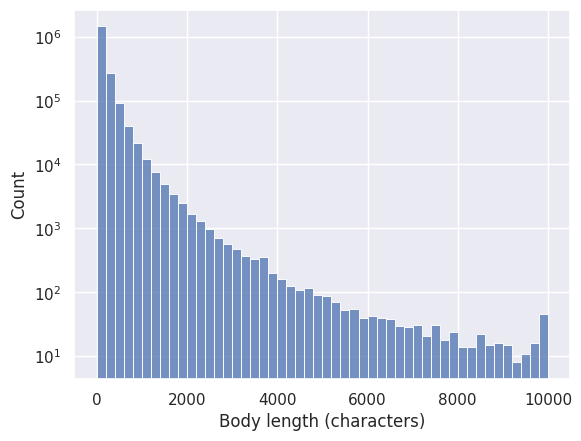

In [18]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [22]:
len(df[lengths >= 10000])

44

In [23]:
# Add a "Time range" column to a dataframe
import datetime

TIME_RANGE = "Time range"
"""Name of the column for storing time range"""

def with_time_range(df):
    dfs = []
    for time_range in config.time_ranges:
        start_time = datetime.datetime.combine(time_range.start_date, datetime.time(0, 0, 0))
        end_time = datetime.datetime.combine(time_range.end_date, datetime.time(0, 0, 0))
        filtered = df[(start_time <= df[TIME]) & (df[TIME] < end_time)].copy()
        filtered[TIME_RANGE] = time_range
        dfs.append(filtered)
    return pd.concat(dfs)

df = with_time_range(df)
df.head(n=3)

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
84,26151686025,2010-01-01 00:01:14,WTF,3lzxf,t3_akc2y,t3_akc2y,1,0,"ok reddit, how long do you think it will be be...","TimeRange(start_date=2010-01-01, min=50000, hi..."
85,26151686057,2010-01-01 00:02:08,reddit.com,NaN,t1_c0i1e33,t3_akfoq,0,0,"for sure, for most it was earlier and for some...","TimeRange(start_date=2010-01-01, min=50000, hi..."
86,26151686346,2010-01-01 00:09:56,Cooking,3c248,t1_c0i13kw,t3_akdkr,2,0,"new year's *day*, yes. where i'm from, pork an...","TimeRange(start_date=2010-01-01, min=50000, hi..."


## Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

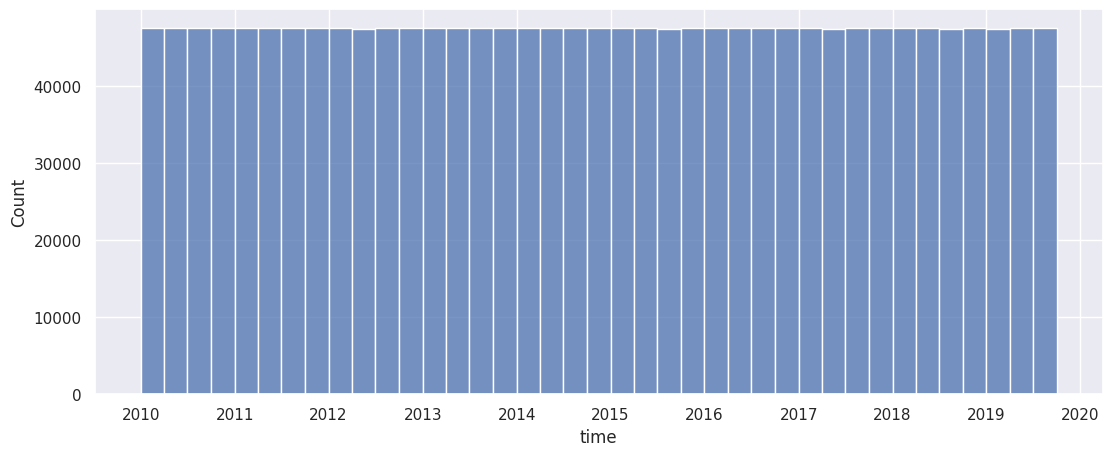

In [24]:
plt.figure(figsize=(13, 5))
sns.histplot(
    data=df,
    x=TIME,
    bins=[
        mpl.dates.date2num(time_range.start_date) for time_range in config.time_ranges
    ],
)

<Axes: xlabel='id', ylabel='hit_rate'>

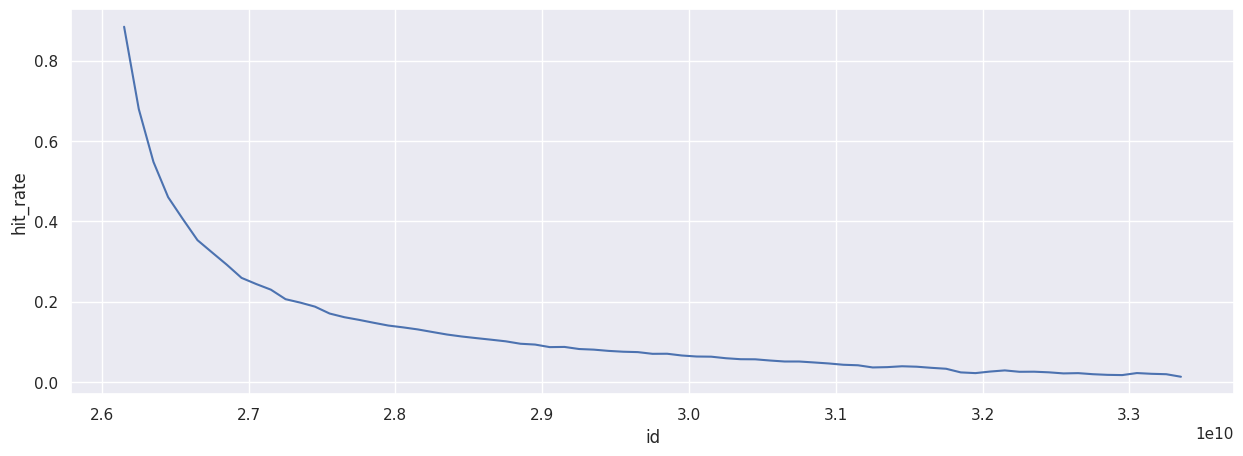

In [25]:
# Hit rates by ID
start = config.time_ranges[0].start_id
end = config.time_ranges[-1].end_id
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    num_hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[(misses > start) & (misses < next_id)])

    if num_misses == 0:
        return 0
    return num_hits / (num_hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "hit_rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="hit_rate")

<Axes: xlabel='Date', ylabel='Hit rate'>

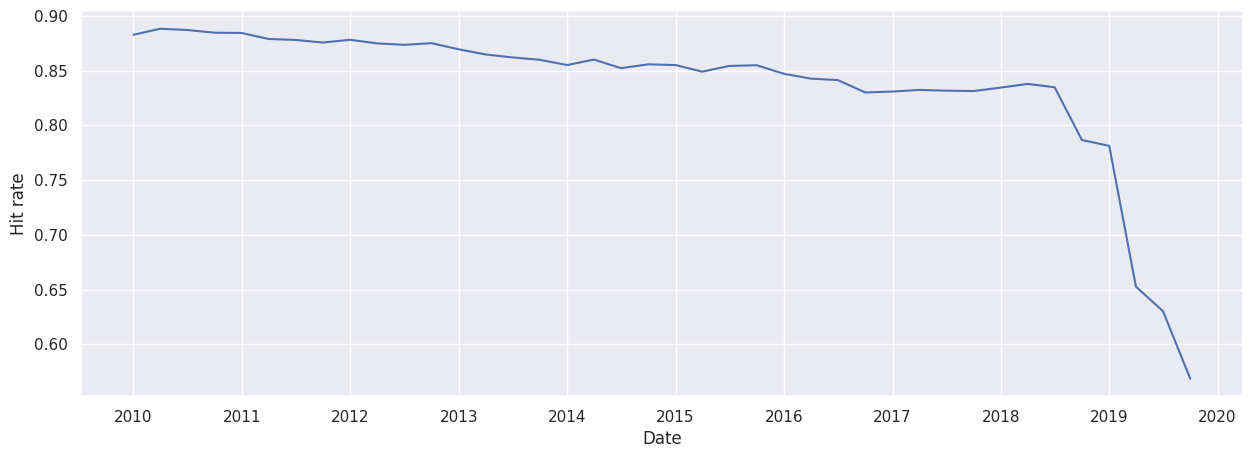

In [26]:
# Approximate hit rate for each time range
ranges = []
for time_range in config.time_ranges:
    num_hits = len(df[(time_range.start_id <= df[ID]) & (df[ID] <= time_range.end_id)])
    num_misses = len(misses[(time_range.start_id <= misses) & (misses <= time_range.end_id)])
    ranges.append([time_range.start_date, num_hits / (num_hits + num_misses)])

data = pd.DataFrame(ranges, columns=["Date", "Hit rate"])
plt.figure(figsize=(15, 5))
sns.lineplot(data, x="Date", y="Hit rate")

<Axes: xlabel='time', ylabel='Count'>

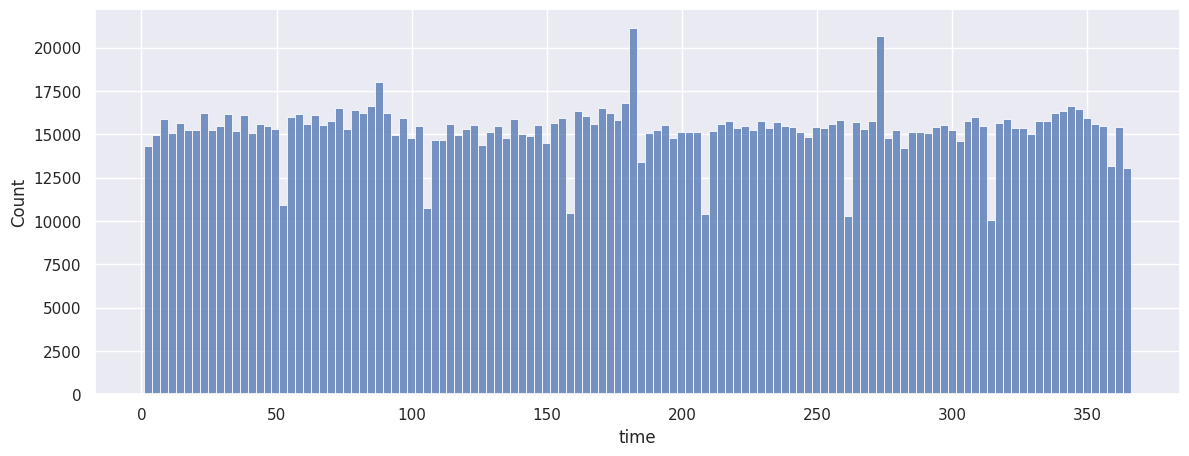

In [27]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

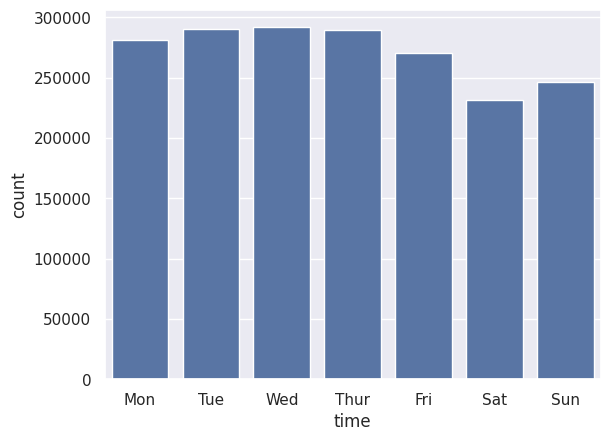

In [28]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

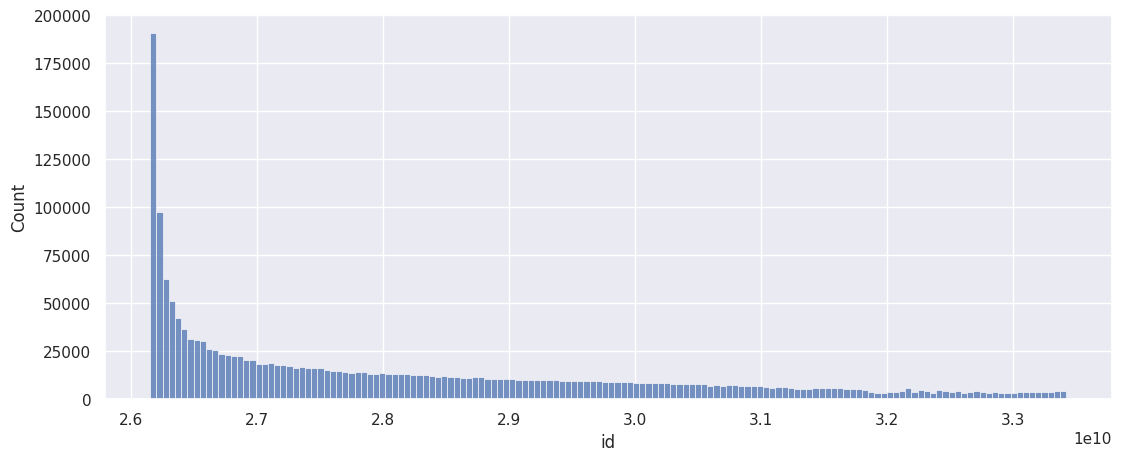

In [25]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df[ID])

In [26]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df[ID].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.6435922724371967, pvalue=0.0, statistic_location=0.29181538184077443, statistic_sign=1)

In [27]:
# The earliest comment we have
df[df[ID] == df[ID].min()]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
84,26151686025,2010-01-01 00:01:14,WTF,3lzxf,t3_akc2y,t3_akc2y,1,0,"ok reddit, how long do you think it will be be...","TimeRange(start_date=2010-01-01, min=50000, hi..."


<Axes: >

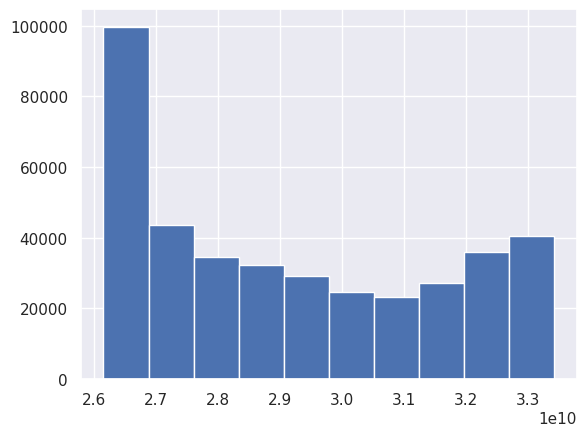

In [28]:
misses.hist()

<Axes: ylabel='Count'>

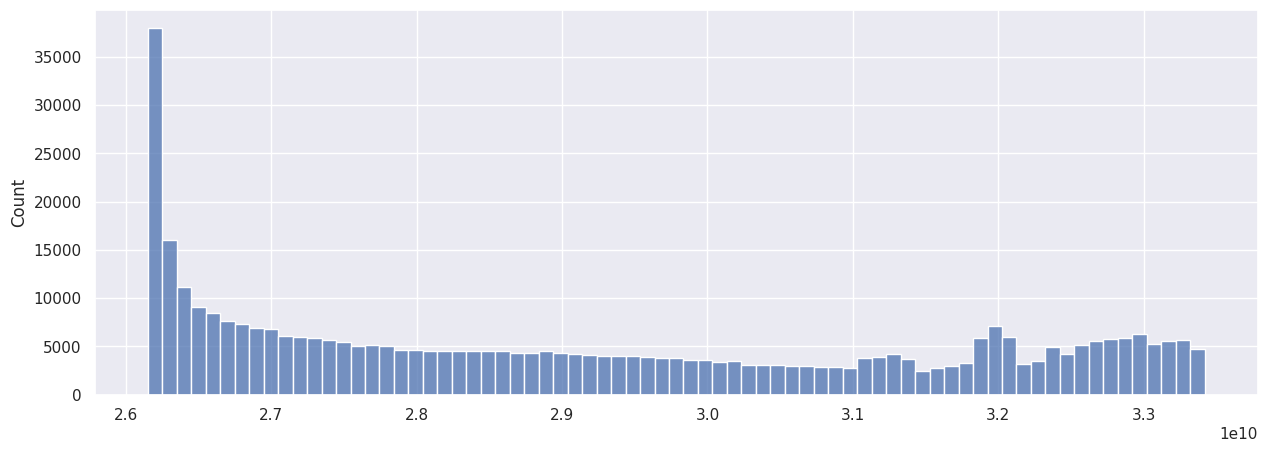

In [29]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

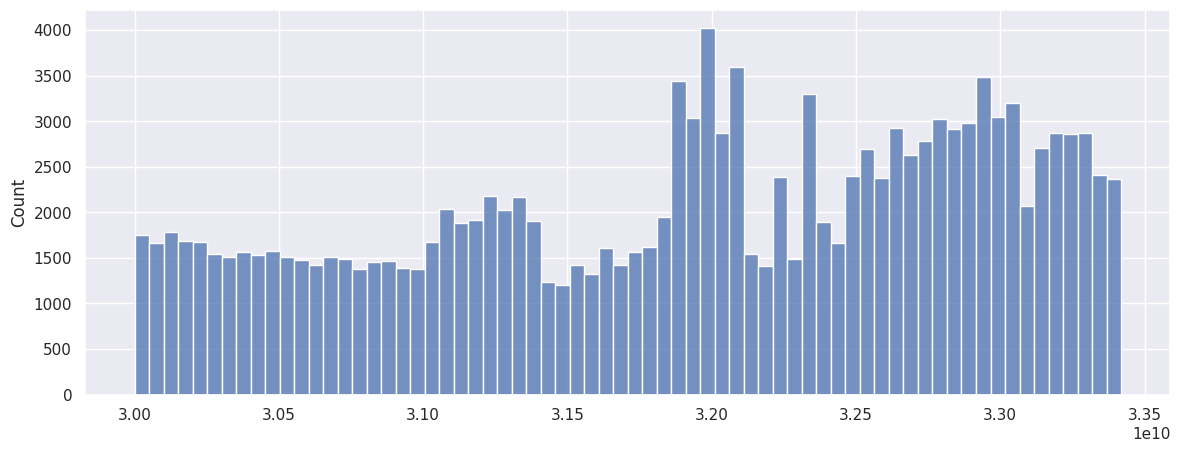

In [30]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [31]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8296221676107236, 0.8296221676107236)

<Axes: xlabel='id', ylabel='rate'>

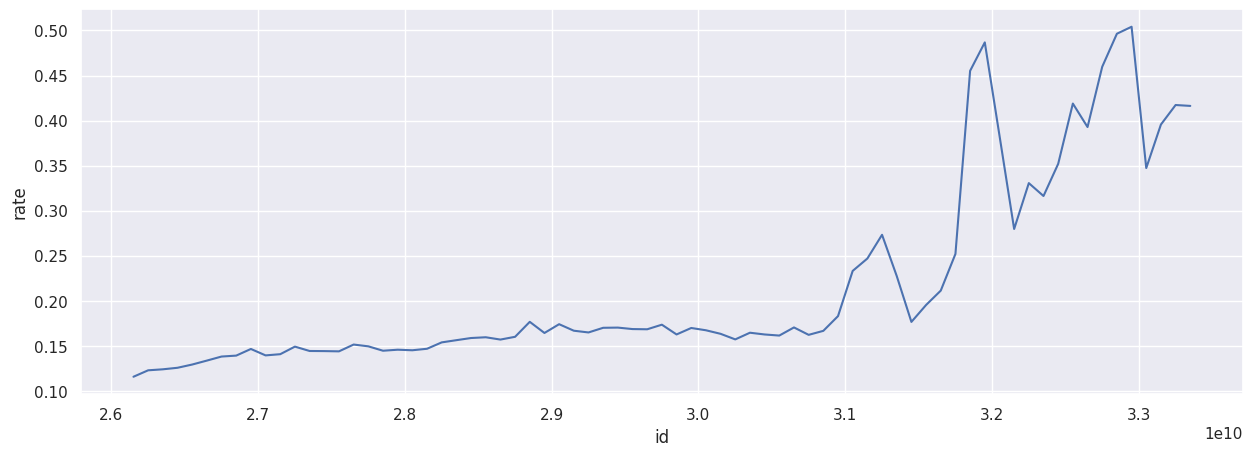

In [32]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [33]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
1521313,30000000548,2018-01-03 15:46:31,CrappyDesign,kq14w,t3_7nwcxp,t3_7nwcxp,1,0,"i'm a bot, *bleep*, *bloop*. someone has linke...","TimeRange(start_date=2018-01-01, min=50000, hi..."
1521314,30000000648,2018-01-03 15:46:33,news,hpdj7,t1_ds54x1y,t3_7nuf0p,1,0,"> which is appointed by the mayor, i presume. ...","TimeRange(start_date=2018-01-01, min=50000, hi..."
1521315,30000004473,2018-01-03 15:47:54,RaiBlocks,ap05j,t3_7nxj2h,t3_7nxj2h,1,0,the consensus so far has been that the raibloc...,"TimeRange(start_date=2018-01-01, min=50000, hi..."
1521316,30000008262,2018-01-03 15:49:13,fireemblem,yplc2,t3_7nx5nt,t3_7nx5nt,28,0,"some of these actually fit, like saber's and i...","TimeRange(start_date=2018-01-01, min=50000, hi..."
1521317,30000009293,2018-01-03 15:49:34,conspiracy,o10qosf,t1_ds57b7x,t3_7nwklc,1,0,thank you,"TimeRange(start_date=2018-01-01, min=50000, hi..."
...,...,...,...,...,...,...,...,...,...,...
1900010,33418663200,2019-12-31 18:39:04,videos,14cwr7,t3_ei3zx5,t3_ei3zx5,-4,0,it's not so much the names that are funny but ...,"TimeRange(start_date=2019-10-01, min=50000, hi..."
1900011,33418693376,2019-12-31 18:46:49,GonewildGBUK,57nk6h9s,t3_ei9vhh,t3_ei9vhh,0,0,well if you need an extra cock in 2020 😜😈😈happ...,"TimeRange(start_date=2019-10-01, min=50000, hi..."
1900012,33418700835,2019-12-31 18:48:40,unpopularopinion,g8vguuw,t3_ei2udf,t3_ei2udf,1,0,it's also a stereotype that kids visit each pa...,"TimeRange(start_date=2019-10-01, min=50000, hi..."
1900013,33418710516,2019-12-31 18:51:06,AskReddit,lp3bf,t3_eiauoe,t3_eiauoe,2,0,"more ass, better ass","TimeRange(start_date=2019-10-01, min=50000, hi..."


In [34]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = (misses_actual - misses_actual.mean()) / misses_actual.std()

res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.10711272388471044, pvalue=0.0, statistic_location=-0.673022862009497, statistic_sign=1)

# Subreddits

In [29]:
df[df[SR_NAME] == "reddit.com"]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
85,26151686057,2010-01-01 00:02:08,reddit.com,NaN,t1_c0i1e33,t3_akfoq,0,0,"for sure, for most it was earlier and for some...","TimeRange(start_date=2010-01-01, min=50000, hi..."
99,26151688760,2010-01-01 01:11:52,reddit.com,3bws6,t3_akfle,t3_akfle,1,0,>pacific mountain time zone\n\ngmt minus wtf?,"TimeRange(start_date=2010-01-01, min=50000, hi..."
100,26151688939,2010-01-01 01:16:14,reddit.com,3kbhj,t1_c0i0yep,t3_ak8iy,1,0,"once again, excellent suggestion.","TimeRange(start_date=2010-01-01, min=50000, hi..."
113,26151690758,2010-01-01 02:03:58,reddit.com,3ram5,t3_akgbg,t3_akgbg,1,0,genuine class,"TimeRange(start_date=2010-01-01, min=50000, hi..."
121,26151692913,2010-01-01 02:57:51,reddit.com,3sv0p,t3_ake99,t3_ake99,1,0,i could have sworn the world was doomed when g...,"TimeRange(start_date=2010-01-01, min=50000, hi..."
...,...,...,...,...,...,...,...,...,...,...
346446,26294850892,2011-10-28 17:37:25,reddit.com,5kdvp,t1_c2snvq4,t3_j6kft,1,0,im a slow person,"TimeRange(start_date=2011-10-01, min=50000, hi..."
348873,26296954303,2011-11-02 17:09:59,reddit.com,4w480,t3_lbnva,t3_lbnva,1,0,"wait! i got this!\n\nspanking? no, no! wanking!","TimeRange(start_date=2011-10-01, min=50000, hi..."
354947,26302381341,2011-11-14 16:52:02,reddit.com,37j4,t1_c2zljbv,t3_2mg72,3,0,fibonacci[7962]\n\n`4074803477 8997284660 1798...,"TimeRange(start_date=2011-10-01, min=50000, hi..."
361473,26308157761,2011-11-27 16:41:00,reddit.com,NaN,t1_c335gf8,t3_lfaqi,1,0,and you came back to tell me this? that is kin...,"TimeRange(start_date=2011-10-01, min=50000, hi..."


In [30]:
# Most popular subreddits
df[df[SR_NAME] != "reddit.com"][SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit              192443
pics                    52891
funny                   41546
politics                39213
gaming                  34883
WTF                     25919
leagueoflegends         22466
worldnews               20831
IAmA                    20352
videos                  18055
atheism                 17779
nfl                     17112
todayilearned           16838
nba                     15419
AdviceAnimals           15163
trees                   14879
soccer                  13243
fffffffuuuuuuuuuuuu     11239
news                    11234
movies                  11136
Name: count, dtype: int64

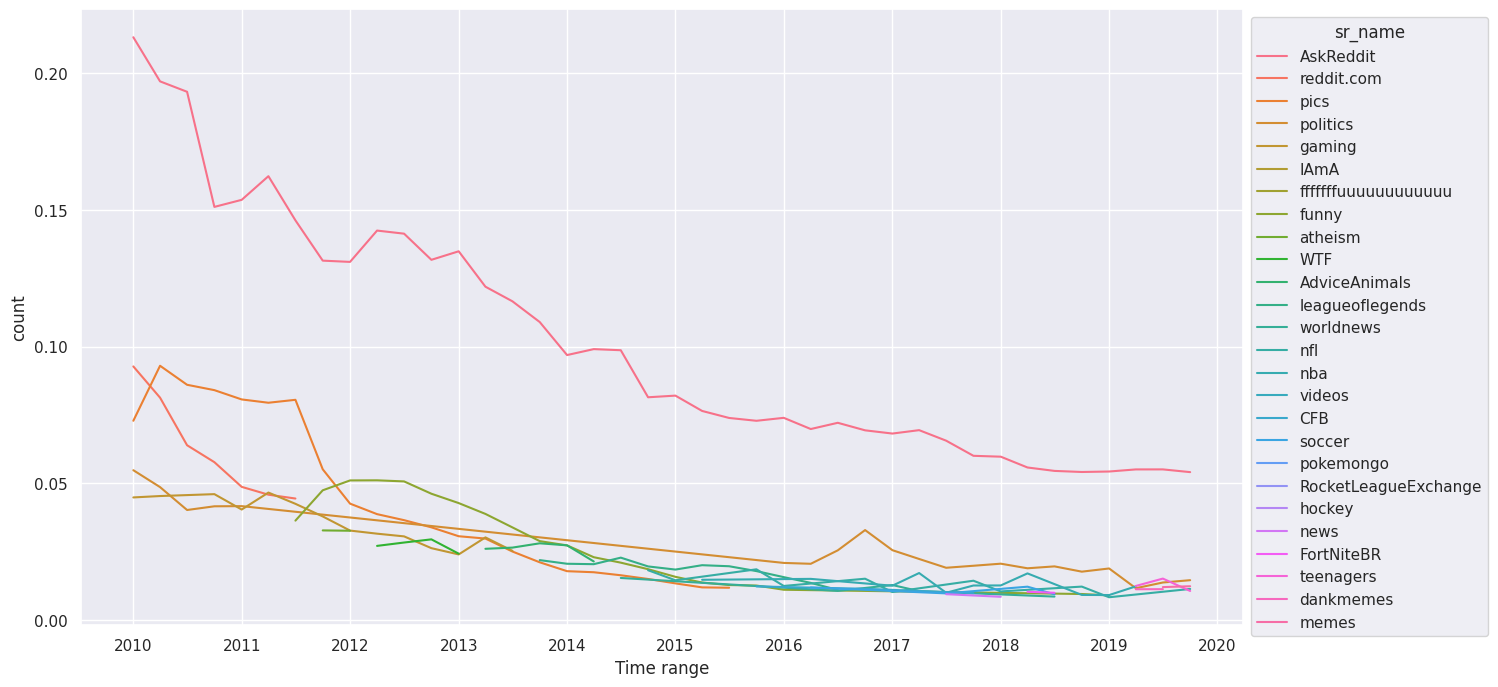

In [31]:
# this looks at *count* rather than percent of comments from each subreddit
# todo fix that (oversampling thing)

data = df.groupby(TIME_RANGE).apply(lambda df: df[SR_NAME].value_counts(normalize=True).nlargest(5), include_groups=False)
data = data.to_frame("count").reset_index()
data[TIME_RANGE] = data[TIME_RANGE].apply(lambda tr: tr.start_date)

plt.figure(figsize=(15, 8))
ax = sns.lineplot(data, x=TIME_RANGE, y="count", hue=SR_NAME)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Text cleaning

In [15]:
# Doing this stuff on all comments is slow, so let's just try it on a small sample
sample_df = pl.from_pandas(df.sample(n=5000, random_state=123).reset_index(drop=True))

In [16]:
# umarkdown and BeautifulSoup let us Markdown
!pip install bs4 umarkdown

/usr/lib/python3.11/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid, fd = os.forkpty()


In [17]:
from bs4 import BeautifulSoup
from umarkdown import markdown

def parse_markdown(body: str):
    html = markdown(body)
    soup = BeautifulSoup(html, features="html.parser")
    return soup.get_text(" ").strip()

In [20]:
!pip install lingua-language-detector

In [34]:
# Filter out non-English comments
# TODO actually do it

from lingua import Language, LanguageDetectorBuilder

# Most popular languages gotten from
# https://towardsdatascience.com/the-most-popular-languages-on-reddit-analyzed-with-snowflake-and-a-java-udtf-4e58c8ba473c
detector = LanguageDetectorBuilder.from_languages(
    Language.ENGLISH, Language.GERMAN, Language.SPANISH, Language.PORTUGUESE
).build()

text = "spam"

print("Detected language:", detector.detect_language_of(text))
detector.compute_language_confidence_values(text)

Detected language: Language.PORTUGUESE


[ConfidenceValue(language=Language.PORTUGUESE, value=0.3776183267405699),
 ConfidenceValue(language=Language.SPANISH, value=0.23092198072911876),
 ConfidenceValue(language=Language.GERMAN, value=0.20455744953575403),
 ConfidenceValue(language=Language.ENGLISH, value=0.1869022429945573)]

In [18]:
sample_df = sample_df.with_columns(parsed=pl.col(BODY).map_elements(parse_markdown, return_dtype=pl.String))
sample_df

id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,parsed
i64,datetime[ns],str,str,str,str,i64,i64,str,str
26592340459,2013-01-06 22:32:21,"""BicyclingCirclejerk""","""9u4jn""","""t1_c7ngjk5""","""t3_15kxcu""",2,0,"""Naw man. Twist those shits tog…","""Naw man. Twist those shits tog…"
30896293581,2018-10-01 10:03:30,"""mcgill""","""10o81n""","""t3_9kggjl""","""t3_9kggjl""",31,0,"""Nobody will care about you not…","""Nobody will care about you not…"
29346653412,2017-05-09 14:35:56,"""Emailmarketing""","""135pq3""","""t3_6a08u6""","""t3_6a08u6""",1,0,"""List cleaning services can be …","""List cleaning services can be …"
29125535052,2017-02-13 05:06:17,"""science""","""13ldzj""","""t3_5tlb8c""","""t3_5tlb8c""",1,0,"""I believe in evolution and not…","""I believe in evolution and not…"
30457347967,2018-05-28 10:13:21,"""worldnews""","""8c6kw""","""t3_8mpvqp""","""t3_8mpvqp""",2,0,"""So much potential for really u…","""So much potential for really u…"
…,…,…,…,…,…,…,…,…,…
30513128081,2018-06-13 19:28:31,"""taxpros""","""99a2z""","""t3_8qdwm6""","""t3_8qdwm6""",1,0,"""I think my state(NV) requires …","""I think my state(NV) requires …"
27797809554,2015-05-30 14:46:18,"""HotPeppers""","""5wvp4""","""t1_crpl3cl""","""t3_37pjan""",1,0,"""Easier said than done in my ar…","""Easier said than done in my ar…"
29088203875,2017-01-29 13:56:13,"""paragon""",null,"""t1_dd1wu57""","""t3_5qs432""",1,0,"""I might be in minority, but I …","""I might be in minority, but I …"


In [35]:
from nltk.tokenize.casual import TweetTokenizer
import re
import unicodedata

tokenizer = TweetTokenizer()


def casual_tokenize(text: str) -> str:
    text = unicodedata.normalize("NFKD", text)
    text = re.sub("[uU]/[A-Za-z_-]+", " ", text)
    text = re.sub("[rR]/[A-Za-z_.-]+", " ", text)
    text = text.replace("\n", " ")
    text = text.replace(r"\n", " ")
    # Kind of a dumb way to remove links but I'm like 90% sure it works
    no_links = [
        tok for tok in tokenizer.tokenize(text) if not re.match("https?://", tok)
    ]
    # Remove all tokens that only contain non-word characters
    no_symbol_tokens = [
        tok for tok in tokenizer.tokenize(text) if re.match("[A-Za-z]", tok)
    ]
    return " ".join(no_symbol_tokens)

In [36]:
sample_df.with_columns(tokenized=pl.col(BODY).map_elements(casual_tokenize, return_dtype=pl.String))

id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,parsed,tokenized
i64,datetime[ns],str,str,str,str,i64,i64,str,str,str
26592340459,2013-01-06 22:32:21,"""BicyclingCirclejerk""","""9u4jn""","""t1_c7ngjk5""","""t3_15kxcu""",2,0,"""Naw man. Twist those shits tog…","""Naw man. Twist those shits tog…","""Naw man Twist those shits toge…"
30896293581,2018-10-01 10:03:30,"""mcgill""","""10o81n""","""t3_9kggjl""","""t3_9kggjl""",31,0,"""Nobody will care about you not…","""Nobody will care about you not…","""Nobody will care about you not…"
29346653412,2017-05-09 14:35:56,"""Emailmarketing""","""135pq3""","""t3_6a08u6""","""t3_6a08u6""",1,0,"""List cleaning services can be …","""List cleaning services can be …","""List cleaning services can be …"
29125535052,2017-02-13 05:06:17,"""science""","""13ldzj""","""t3_5tlb8c""","""t3_5tlb8c""",1,0,"""I believe in evolution and not…","""I believe in evolution and not…","""I believe in evolution and not…"
30457347967,2018-05-28 10:13:21,"""worldnews""","""8c6kw""","""t3_8mpvqp""","""t3_8mpvqp""",2,0,"""So much potential for really u…","""So much potential for really u…","""So much potential for really u…"
…,…,…,…,…,…,…,…,…,…,…
30513128081,2018-06-13 19:28:31,"""taxpros""","""99a2z""","""t3_8qdwm6""","""t3_8qdwm6""",1,0,"""I think my state(NV) requires …","""I think my state(NV) requires …","""I think my state NV requires y…"
27797809554,2015-05-30 14:46:18,"""HotPeppers""","""5wvp4""","""t1_crpl3cl""","""t3_37pjan""",1,0,"""Easier said than done in my ar…","""Easier said than done in my ar…","""Easier said than done in my ar…"
29088203875,2017-01-29 13:56:13,"""paragon""",null,"""t1_dd1wu57""","""t3_5qs432""",1,0,"""I might be in minority, but I …","""I might be in minority, but I …","""I might be in minority but I d…"


In [34]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Uncomment this the first time you run this code block
# nltk.download("wordnet")
# nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

tokens = casual_tokenize("They're going to the mall")
tags = pos_tag(tokens)

def treebank_tag_to_wordnet_tag(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# TODO this doesn't handle contractions, use spaCy instead
[lemmatizer.lemmatize(word, treebank_tag_to_wordnet_tag(tag)) for word, tag in tags]

["They're", 'go', 'to', 'the', 'mall']

# N-grams

In [42]:
import itertools
import nltk

bigrams = itertools.chain.from_iterable(sample_df["casual_tokenized"].map(nltk.bigrams))
trigrams = itertools.chain.from_iterable(sample_df["casual_tokenized"].map(nltk.trigrams))
fdist = nltk.FreqDist(itertools.chain(bigrams, trigrams))
ngram_df = pd.DataFrame(
    [
        [ngram, fdist[ngram]]
        for ngram in fdist
        if all(isinstance(tok, str) for tok in ngram)
    ],
    columns=["ngram", "freq"],
)
ngram_df

,ngram,freq
0,"(of, the)",482
1,"(in, the)",460
2,"(to, be)",283
3,"(if, you)",242
4,"(on, the)",234
...,...,...
213449,"(legacy, and, vintage)",1
213450,"(and, vintage, shall)",1
213451,"(vintage, shall, continue)",1
213452,"(shall, continue, to)",1


In [43]:
def relevant_ngram(ngram, keywords=keywords):
    for token in ngram:
        for kw in keywords:
            try:
                if kw in token:
                    return True
            except TypeError as e:
                print(kw, ngram)
                raise e
    return False


ngram_df[ngram_df["ngram"].map(lambda ngram: relevant_ngram(ngram, keywords=["anx", "abus"]))].head()

,ngram,freq
12388,"(the, abuse)",2
12389,"(abuse, of)",2
15304,"(an, abusive)",2
18770,"(violence, the, abuse)",2
18771,"(the, abuse, of)",2


# Contextual embeddings

In [38]:
!pip install transformers

In [19]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

/usr/lib/python3.11/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid, fd = os.forkpty()


Looking in indexes: https://download.pytorch.org/whl/cu118


In [33]:
import torch
from transformers import BertModel, BertTokenizer

# From https://medium.com/@r3d_robot/getting-contextualized-word-embeddings-with-bert-20798d8b43a4
model = BertModel.from_pretrained(
    "bert-base-uncased",
    output_hidden_states=True,
)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens)  # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    return tokenized_text, tokens_tensor, segments_tensor


def get_bert_embeddings(tokens_tensor, segments_tensor):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation id disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]  # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1, 0, 2)
    # intialized list to store embeddings
    token_vecs_sum = []  # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence    # loop over tokens in sentence
    for token in token_embeddings:  # "token" is a [12 x 768] tensor
        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    return token_vecs_sum

In [ ]:
sentences = [
    "bank",
    "he eventually sold the shares back to the bank at a premium.",
    "the bank strongly resisted cutting interest rates.",
    "the bank will supply and buy back foreign currency.",
    "the bank is pressing us for repayment of the loan.",
    "the bank left its lending rates unchanged.",
    "the river flowed over the bank.",
    "tall, luxuriant plants grew along the river bank.",
    "his soldiers were arrayed along the river bank.",
    "wild flowers adorned the river bank.",
    "two fox cubs romped playfully on the river bank.",
    "the jewels were kept in a bank vault.",
    "you can stow your jewellery away in the bank.",
    "most of the money was in storage in bank vaults.",
    "the diamonds are shut away in a bank vault somewhere.",
    "thieves broke into the bank vault.",
    "can I bank on your support?",
    "you can bank on him to hand you a reasonable bill for your services.",
    "don't bank on your friends to help you out of trouble.",
    "you can bank on me when you need money.",
    "i bank on your help.",
]

from collections import OrderedDict

context_embeddings = []
context_tokens = []
context_sentences = []

just_trauma = (
    pl_df.lazy()
    .filter(pl.col(BODY).str.contains("trauma"))
    .select(BODY)
    .collect()
    .to_series()
)

for sentence in just_trauma:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(
        sentence, tokenizer
    )
    # todo handle long sentences
    if tokens_tensor.size(dim=1) > 512:
        continue
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors)
    # make ordered dictionary to keep track of the position of each   word
    tokens = OrderedDict()
    # loop over tokens in sensitive sentence
    for token in tokenized_text[1:-1]:
        # TODO account for subword tokenization
        if token != "trauma":
            continue
        # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1  # compute the position of the current token
        token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
        current_index = token_indices[
            tokens[token] - 1
        ]  # get the corresponding embedding
        token_vec = list_token_embeddings[current_index]

        # save values
        context_tokens.append(token)
        context_embeddings.append(token_vec)
        context_sentences.append(sentence)

In [43]:
# For visualizing at https://projector.tensorflow.org/

import csv

with open("metadata_output.tsv", "w+") as file_metadata, open(
    "embeddings_small.tsv", "w+"
) as tsvfile:
    writer = csv.writer(tsvfile, delimiter="\t")
    for token, embedding, sentence in zip(
        context_tokens, context_embeddings, context_sentences
    ):
        if token != "trauma":
            continue
        file_metadata.write(sentence + "\n")
        writer.writerow(embedding.numpy())

In [71]:
# Clustering
from sklearn.cluster import *

trauma_embeddings_with_inds = [
    (i, embedding)
    for i, embedding in enumerate(context_embeddings)
    if context_tokens[i] == "trauma"
]
trauma_embeddings = [embedding for i, embedding in trauma_embeddings_with_inds]

# clustering = DBSCAN(eps=0.01, min_samples=2).fit(trauma_embeddings)
# clustering = HDBSCAN(min_cluster_size=5).fit(trauma_embeddings)
# clustering = OPTICS().fit(trauma_embeddings)
# clustering = KMeans().fit(trauma_embeddings)
clustering = AffinityPropagation(verbose=True).fit(trauma_embeddings)
pd.Series(clustering.labels_).value_counts()

Converged after 27 iterations.


44    45
9     38
22    33
10    31
4     29
21    24
35    23
18    23
31    22
37    21
17    20
29    18
7     18
6     18
26    18
28    16
15    16
32    16
23    15
40    14
8     14
49    14
38    13
41    13
27    13
34    12
16    11
46    11
11    10
20    10
3     10
1     10
45    10
2      8
13     8
5      8
25     7
39     7
30     6
0      6
47     5
19     5
48     5
24     4
14     4
42     4
12     4
33     3
43     3
36     2
Name: count, dtype: int64

In [66]:
# For visualizing at https://projector.tensorflow.org/

import csv

with open("metadata_output.tsv", "w+") as file_metadata, open(
    "embeddings_small.tsv", "w+"
) as tsvfile:
    file_metadata.write("Sentence\tCluster\n")
    writer = csv.writer(tsvfile, delimiter="\t")
    for (i, embedding), cluster in zip(trauma_embeddings_with_inds, clustering.labels_):
        token = context_tokens[i]
        sentence = context_sentences[i]
        if token != "trauma":
            continue
        file_metadata.write(f"{sentence}\t{cluster}\n")
        writer.writerow(embedding.numpy())